In [1]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib notebook

# load up dependencies and functions, Note pyGSSHA_functions.py and  GSSHA.exe MUST be in kernal's working dir
%run pyGSSHA_functions.py

Website notes: 
https://dashboard.waterdata.usgs.gov/app/nwd/en/?aoi=state-hi
https://waterdata.usgs.gov/monitoring-location/16611500/#parameterCode=00065&startDT=2022-07-01&endDT=2023-07-01
https://waterdata.usgs.gov/monitoring-location/16611500/#parameterCode=00065&period=P7D

# Start with modeling 

#### Read in Rainfall Data 

In [2]:
# There needs to be a cell in here that reads in a rainfall file into memory, 
Input_Precip_File = os.path.join(".", "data", "PuuKukuiRain_2022-2023.csv")
Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

### Lovely data cleaning steps
Input_Precip_df = Input_Precip_df.replace(-999999, np.nan)   # Replace all the bunk as no data values 
Input_Precip_df = Input_Precip_df.tz_localize(None).shift(-10, freq='H')         # Scrub out the Timezone awareness of the index

###  read in the Observed stream HEIGHT data too
Input_Stream_df = pd.read_csv(os.path.join(".", "data", 'S_Waiehu_stream_2022-2023.csv'))#.set_index('datetime')
Input_Stream_df['datetime'] = pd.to_datetime(Input_Stream_df['datetime'], errors='coerce')

### Lovely data cleaning steps
Input_Stream_df = Input_Stream_df.replace(-999999, np.nan)
Input_Stream_df.set_index('datetime', inplace=True)
Input_Stream_df = Input_Stream_df.tz_localize(None).shift(-10, freq='H')         # Scrub out the Timezone awareness of the index

#StreamFlow_column_Name = 'SWaiehuFlow'

# and also make a dataframe of the biggest events to use while iterating
#biguns = Biguns_large_event_finder(Input_Stream_df, StreamFlow_column_Name, num_top_events = 30, resample_timestep='1D')

In [3]:
# Clean dataframes a little more
Input_Precip_df = Input_Precip_df[['00045']]
Input_Precip_df.rename(columns={'00045': 'RF_in'}, inplace=True)
Input_Precip_df['RF_mm'] = Input_Precip_df['RF_in']*25.4

# Resample to hourly
Input_Precip_df = Input_Precip_df.resample('60T').sum()

<IPython.core.display.Javascript object>


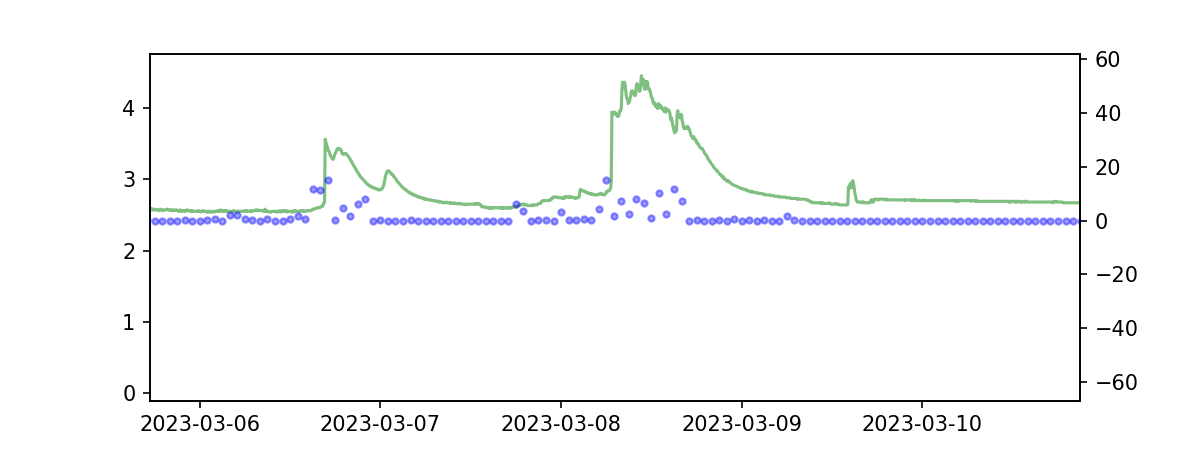

In [25]:
# Plot rainfall and stream height
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()

lns0 = ax2.plot(Input_Precip_df['RF_mm'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(Input_Stream_df['00065'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed


#Good rainfall streamflow events according to graph 
#01-21-2023 - 02-03-2023
#10-25-2022 - 10- 29 2022

#02-26-23 to 3-4-2023
#3-04-23  to 3-06-23
# 11-24-22 to 11-26-23

In [5]:
# Ready  Parameters list 
Code_list_in_WMS = [
    "-104",
"-105",
"-106",
"-107",
"-108",
"-109",
"-1010",
"-1011",
"-1012",
"-1013",
"-1014",
"-1015",
"-1016",
"-1017",
"-1018",
"-1019",
"-1021",
"-1022",
"-1024",
"-1025",
"-201",
"-211",
"-221",
"-231",
"-241",
"-251",
"-261",
"-205",
"-215",
"-225",
"-235",
"-245",
"-255",
"-265",
"-206",
"-216",
"-226",
"-236",
"-246",
"-256",
"-266",
"-207",
"-217",
"-227",
"-237",
"-247",
"-257",
"-267",
"-208",
"-218",
"-228",
"-238",
"-248",
"-258",
"-268",
"-209",
"-219",
"-229",
"-239",
"-249",
"-259",
"-269",
"-2011",
"-2111",
"-2211",
"-2311",
"-2411",
"-2511",
"-2611"]

#Read in frame of base values for all other parameter codes not explicitly modified by the above cell 
Code_Key_df = pd.read_csv(os.path.join('.', 'data', 'Parameter_Codes_SWaiehu_Mod1.csv')) 

### Parameters for gag and other files

In [85]:
PrjName = 'v1_50m_SWaiehu_ParamsReady_RUN'
Input_Precip_df = Input_Precip_df
Precip_column_Name = "RF_mm"
# Event Variables 
StartDate   =  "2022-10-25 00:00"
EndDate     =    "2022-10-29 00:00"
RainSeries_timestep_Mins = 60
Lat  = "756666.0"      # For Waihehe 753354,    # For WaiehuKou,"758000.0"    # for Iao 753250 # for SWaiehu "756666.0" 
Lon  = "2313888.0"      # For Waihehe 2314472,   # For WaiehuKou,"2315555.0"   # for Iao 2310140 # for SWaiehu "2313888.0" 
RUN_dir = os.path.join('.', 'RUN')

StreamFlow_column_Name = '00065'

#### Modify parameters here

In [86]:
#param_code = '-1010'
#param_val  = ".5"

In [87]:
refresh_model(PrjName)    # Nuke out the RUN directory to start fresh

# Set the parameters in the cmt file
cmt_prama_jama(param_code, param_val, PrjName)   # Set the parameter(s) for the run
assign_cmt_base_vals(Code_Key_df, Code_list_in_WMS, PrjName)  # Use the dataframe and list of parameters above to assign the base values to all 


# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")


# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

<IPython.core.display.Javascript object>


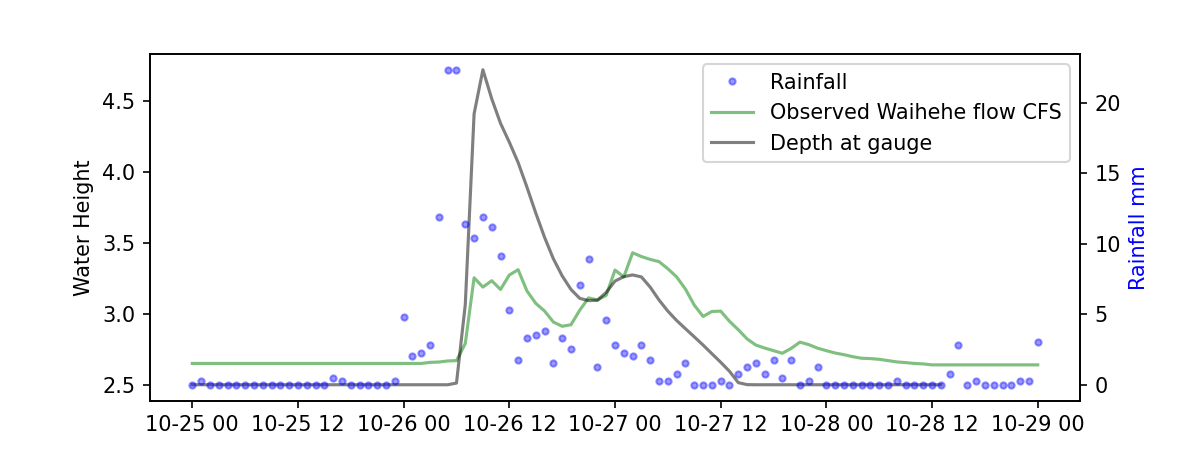

In [108]:
dep_file  = os.path.join('.', "RUN", '{}.dep'.format(PrjName))
Cell_to_Extract = [5,145] # [22, 110]

# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins


# Cell geometry from the WMS model 
NumRowsCells  = 63
NumCols_Cells = 146
# Timestep stuff
NumTS_to_Process    = int(Num_steps_in_sim -10)
Timestep_len_mins   = 60
Start_DateTime      = StartDate

# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.5

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

#plt.title("{} - NSE={}, time={}_sec".format(RunID,
#                                         round(NSE_stat, 2), round(elapsed, 0)))

# Work from here

In [70]:

##### RUN ISOLATED GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

<IPython.core.display.Javascript object>


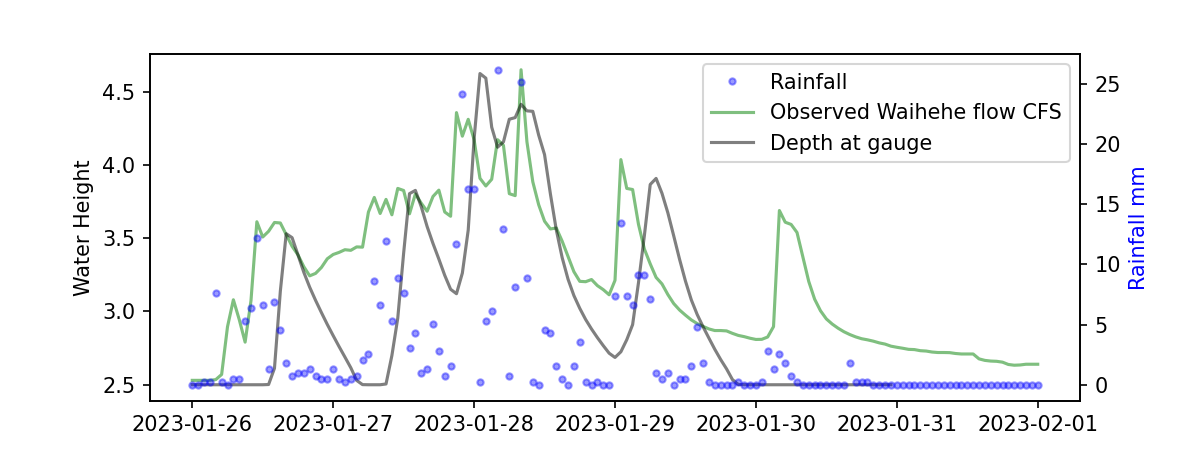

In [72]:
dep_file  = os.path.join('.', "RUN", '{}.dep'.format(PrjName))
Cell_to_Extract = [5,145] # [22, 110]

# Cell geometry from the WMS model 
NumRowsCells  = 63
NumCols_Cells = 146
# Timestep stuff
NumTS_to_Process    = 120
Timestep_len_mins   = 60
Start_DateTime      = StartDate

# Run it!
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.5


    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

#plt.title("{} - NSE={}, time={}_sec".format(RunID,
#                                         round(NSE_stat, 2), round(elapsed, 0)))

# Replicate for multiple events

In [49]:
PrjName = 'v1_50m_SWaiehu_ParamsReady_RUN'
Input_Precip_df = Input_Precip_df
Precip_column_Name = "RF_mm"
# Event Variables 
RainSeries_timestep_Mins = 60
Lat  = "756666.0"      # For Waihehe 753354,    # For WaiehuKou,"758000.0"    # for Iao 753250 # for SWaiehu "756666.0" 
Lon  = "2313888.0"      # For Waihehe 2314472,   # For WaiehuKou,"2315555.0"   # for Iao 2310140 # for SWaiehu "2313888.0" 
RUN_dir = os.path.join('.', 'RUN')

StreamFlow_column_Name = '00065'

# Cell geometry from the WMS model 
NumRowsCells  = 63
NumCols_Cells = 146

dep_file  = os.path.join('.', "RUN", '{}.dep'.format(PrjName))
Cell_to_Extract = [5,145] # [22, 110]

# Each cell is one run 

In [50]:
NSE_LIST = []

### Run 1   "2022-10-25"

<IPython.core.display.Javascript object>


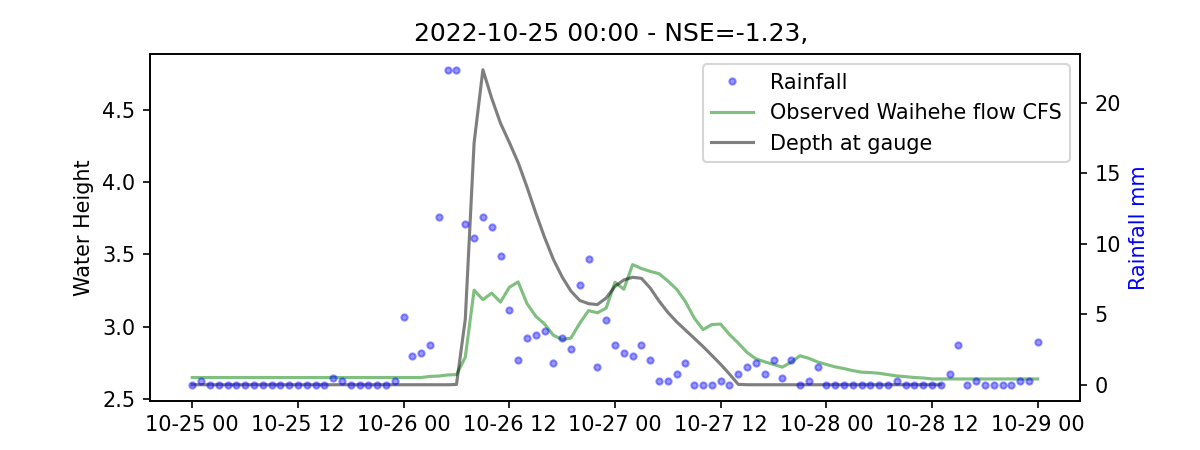

In [51]:
StartDate   =  "2022-10-25 00:00"
EndDate     =    "2022-10-29 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.6

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

### Run 2   "2023-01-26"

<IPython.core.display.Javascript object>


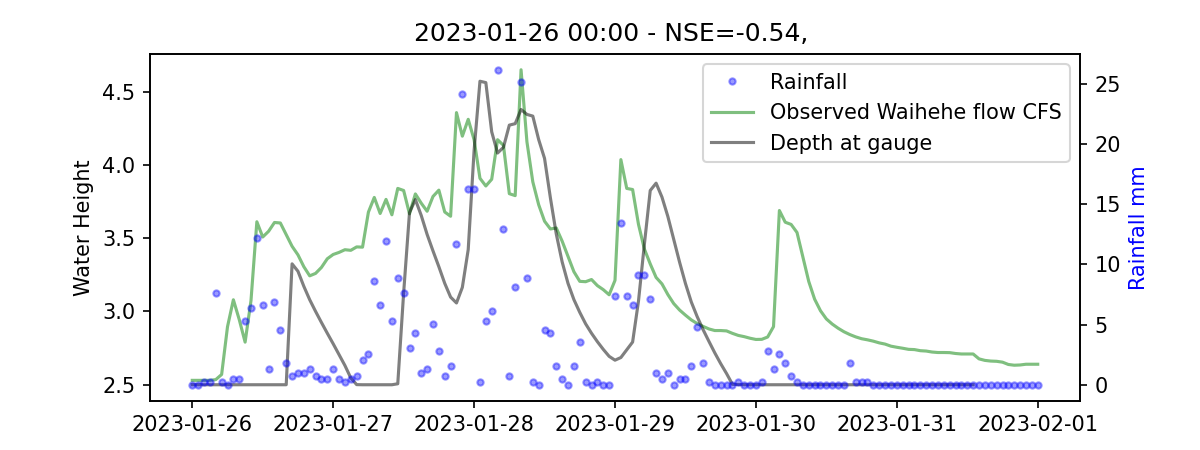

In [52]:
StartDate   =  "2023-01-26 00:00"
EndDate     =    "2023-02-1 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.5

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

### Run 3  2022-11-24 

<IPython.core.display.Javascript object>


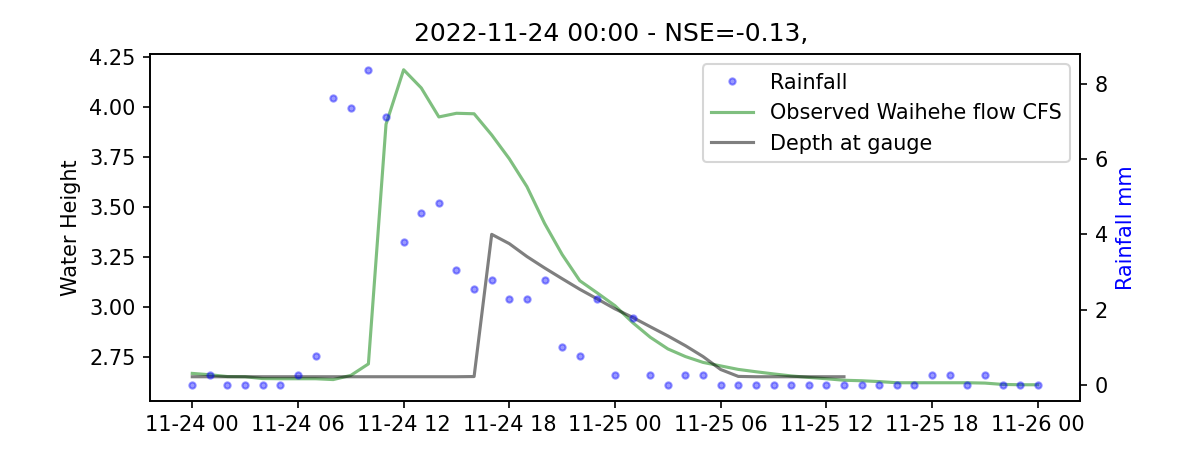

In [53]:
StartDate   =  "2022-11-24 00:00"
EndDate     =    "2022-11-26 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.65

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

### Run 4  2023-03-06

<IPython.core.display.Javascript object>


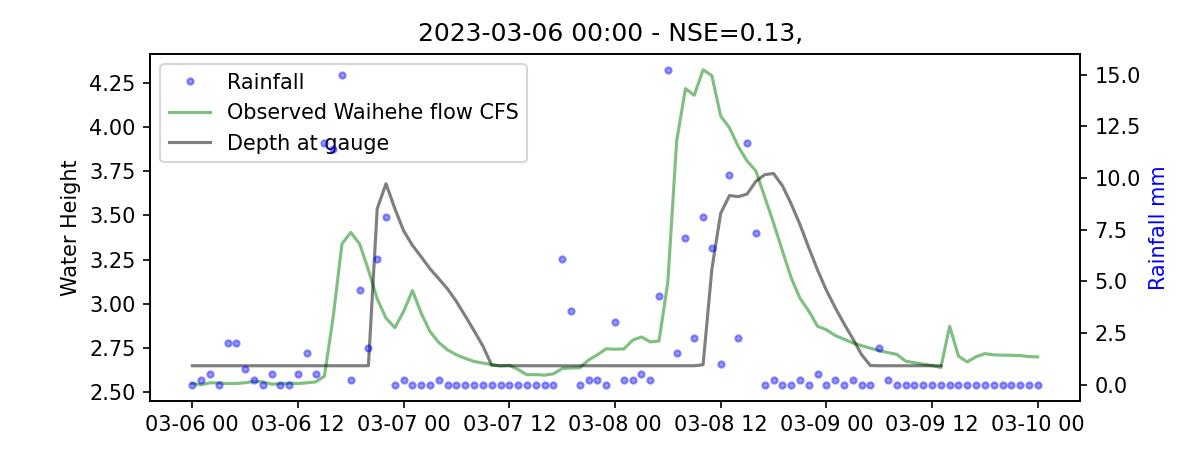

In [54]:
StartDate   =  "2023-03-06 00:00"
EndDate     =    "2023-03-10 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.65

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

## Combined NSE

In [ ]:
print("the Mean NSE is {}".format(round(np.mean(NSE_LIST),2)))
NSE_LIST

In [55]:
THIS IS with soil moisture at .2 

the Mean NSE is -0.44


[-1.2288189805097298,
 -0.5401479717942839,
 -0.12747763468981121,
 0.12682514707453252]

In [48]:
THIS IS with soil moisture at .1 

the Mean NSE is -0.4


[-1.038504773097808,
 -0.5683416809399435,
 -0.15073639014178397,
 0.14113110629272974]

In [42]:
THIS IS with soil moisture at .3 

the Mean NSE is -0.44


[-1.4525658269968371,
 -0.4732140921452159,
 0.02245821987681418,
 0.1453051912318143]

# Old 

In [ ]:
# Postprocessing and plotting 
OutHydro = process_otl_file(StartDate, PrjName)   # Process output hydrograph
RunID =  "Test"# "{}-{}".format(str(Param_1_name), str(param_val))
Plot_and_Compare(OutHydro, SlicedStreamflow_df, Rain_Data_Frame,  RunID, elapsed)

In [ ]:

    
######## Input Params  ###############
# Input Max flood grid file from WMS 
gfl_file = os.path.join('.', "RUN", '{}.gfl'.format(PrjName))

# Cell geometry from the WMS model 
NumRowsCells  = 63
NumCols_Cells = 146


# ASCii geometry, from the Lower Left corner of the model cell 
cellsize = 50
xll = 753486 + (cellsize/2)    # the ASC is based on the center of the Lower Left cell, whereas its easiest to see the corner
yll  = 2312266 + (cellsize/2)  
no_data_val = -99999

Save_filename = "{}_MaxFlood".format(PrjName)
Save_FilePlace = os.path.join(".", "Figures")

# Run the to ASC function
gridmo = WMS_Max_Flood_File_to_ASCii(gfl_file, NumRowsCells, NumCols_Cells,
                           cellsize, xll, yll, no_data_val, Save_filename, Save_FilePlace)

In [ ]:
def WMS_Max_Flood_File_to_ASCii(gfl_file, NumRowsCells, NumCols_Cells,
                           cellsize, xll, yll, no_data_val, Save_filename, Save_FilePlace, 
                                PLOT=True, SAVE=False):
    
    NumCELLS = NumRowsCells* NumCols_Cells

    arr = np.genfromtxt(gfl_file, skip_header=8, delimiter=',')    # delimit with a comma to keep it from using spaces...
    arr = arr[:-1]   # Cut off the last row which says ENDDS
    arr_activecells = arr[0:NumCELLS]
    arr_datacells   =  arr[NumCELLS:]

    gridmo = np.reshape(arr_datacells, (NumRowsCells, NumCols_Cells))
    
    if PLOT: 
        # plot it in python 
        fig, ax = plt.subplots(figsize=(8, 3))
        plt.imshow(gridmo, cmap='gray')      # Plot the data using imshow with gray colormap

    if SAVE:    
        # Save the ASCii File 
        headerstring       = bytes('NCOLS %d\nNROWS %d\nXLLCENTER %f\nYLLCENTER %f\nCELLSIZE %f\nNODATA_value %f\n' % 
            (gridmo.shape[1], gridmo.shape[0], xll, yll, cellsize, no_data_val), 'UTF-8')
        with open(os.path.join(Save_FilePlace, "{}.asc".format(Save_filename)),'wb') as fout:
            fout.write(headerstring)
            np.savetxt(fout,gridmo,'%5.2f')

        # Save the projection file for ArcGIS (Projection might need to be changed depending on WMS projection?) 
        epsg = 'PROJCS["WGS_1984_UTM_Zone_4N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-159],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32604"]],VERTCS["Local",VDATUM["Local"],PARAMETER["Direction",1.0],UNIT["Meter",1.0]]'
        with open(os.path.join(Save_FilePlace, "{}.prj".format(Save_filename)), "w") as prj:
            prj.write(epsg)
            prj.close()

        print("Saved {}.asc at {}".format(Save_filename, Save_FilePlace))
    
    return gridmo

In [ ]:
NumTS_to_Process = 310


#arr = np.genfromtxt(dep_file, skip_header=7, delimiter=',', dtype=str)
#arr = arr[:-1]   # Cut off the last row which says ENDDS

NumCELLS = NumRowsCells* NumCols_Cells
# This is a constant variable for each map, which uses the number of cells to determine how many rows to peel off for each timestep
NumRowsUnit = (NumCELLS*2)+1 # *2 is because the file contains both the mask and values every time, +1 is for the TS line  
# The start of the run in datetime 
datetime_Start = datetime.strptime(Start_DateTime, '%Y-%m-%d %H:%M')

# For each "timestamped map" this will extract the column data, throw away the "active cells mask" half, and give a np array of the map
for unit in range(0, NumTS_to_Process, 1):
    startslice = unit * NumRowsUnit           # Start of the desired data unit
    endslice  = startslice + NumRowsUnit      # End of desired data unit
    arrrr = arr[startslice:endslice]          # a 1-d array containing each timesteps data

    TS = arrrr[0]                             # the text of the Timestep  
    arr_activecells = arrrr[1:NumCELLS+1].astype(float)  # These are the "active cells mask" part (trash)
    arr_datacells   =  arrrr[NumCELLS+1:].astype(float)  # This is the actual data we want 
    
    gridmo = np.reshape(arr_datacells, (NumRowsCells, NumCols_Cells))


    print(arr_datacells.max())
    ## plot it in python 
    #fig, ax = plt.subplots(figsize=(8, 3))
    #plt.imshow(gridmo, cmap='gray')      # Plot the data using imshow with gray colormap